In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
data00=pd.read_csv("/content/Quickestelectriccars-EVDatabase.csv")
daf2=pd.read_excel("/content/EV_charging_station_dataset.xlsx")

### Quickest electric cars

In [22]:
pip install --upgrade category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 6.0 MB/s eta 0:00:00


In [23]:
import plotly.express as px
import seaborn as sns

from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
import category_encoders as ce

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [24]:
print(data00.columns.tolist())

['Name', 'Subtitle', 'Acceleration', 'TopSpeed', 'Range', 'Efficiency', 'FastChargeSpeed', 'Drive', 'NumberofSeats', 'PriceinGermany', 'PriceinUK']


In [25]:
data0=data00.fillna('0')

In [26]:
PriceinUK=[]
for item in data0['PriceinUK']:
    PriceinUK+=[int(item.replace('£','').replace(',',''))]
data0['PriceinUK']=PriceinUK

In [27]:
PriceinGermany=[]
for item in data0['PriceinGermany']:
    PriceinGermany+=[int(item.replace('€','').replace(',',''))]
data0['PriceinGermany']=PriceinGermany

In [28]:
FastChargeSpeed=[]
for item in data0['FastChargeSpeed']:
    FastChargeSpeed+=[int(item.replace(' km/h','').replace('-','0'))]
data0['FastChargeSpeed']=FastChargeSpeed

In [29]:
Efficiency=[]
for item in data0['Efficiency']:
    Efficiency+=[int(item.replace(' Wh/km',''))]
data0['Efficiency']=Efficiency

In [30]:
Range=[]
for item in data0['Range']:
    Range+=[int(item.replace(' km',''))]
data0['Range']=Range

In [31]:
TopSpeed=[]
for item in data0['TopSpeed']:
    TopSpeed+=[int(item.replace(' km/h',''))]
data0['TopSpeed']=TopSpeed

In [32]:
Acceleration=[]
for item in data0['Acceleration']:
    Acceleration+=[float(item.replace(' sec',''))]
data0['Acceleration']=Acceleration

In [33]:
Subtitle=[]
for item in data0['Subtitle']:
    Subtitle+=[float(item.replace('Battery Electric Vehicle | ','').replace(' kWh','').replace('      ',''))]
data0['Subtitle']=Subtitle

In [34]:
df=data0
from sklearn.preprocessing import LabelEncoder
for c in df.columns:
    if df[c].dtype=='object': 
        df[c] = df[c].fillna('N')
        lbl = LabelEncoder()
        lbl.fit(list(df[c].values))
        df[c] = lbl.transform(df[c].values)

In [35]:
data1=df
data1

,Name,Subtitle,Acceleration,TopSpeed,Range,Efficiency,FastChargeSpeed,Drive,NumberofSeats,PriceinGermany,PriceinUK
0,156,200.0,2.1,410,970,206,920,0,4,215000,189000
1,153,90.0,2.6,262,455,198,680,0,7,116990,110980
2,125,83.7,2.8,260,390,215,860,0,4,186336,138830
3,126,83.7,2.9,250,380,220,790,0,4,187746,139910
4,146,200.0,3.0,210,750,267,710,0,7,75000,68000
...,...,...,...,...,...,...,...,...,...,...,...
174,113,68.0,13.3,130,270,252,290,1,7,57440,0
175,111,68.0,13.3,130,270,252,290,1,7,58230,0
176,96,36.0,14.0,123,165,218,170,1,7,43433,30255
177,37,26.8,15.0,125,170,158,120,1,4,20490,0


In [36]:
data1.columns

Index(['Name', 'Subtitle', 'Acceleration', 'TopSpeed', 'Range', 'Efficiency',
       'FastChargeSpeed', 'Drive', 'NumberofSeats', 'PriceinGermany',
       'PriceinUK'],
      dtype='object')

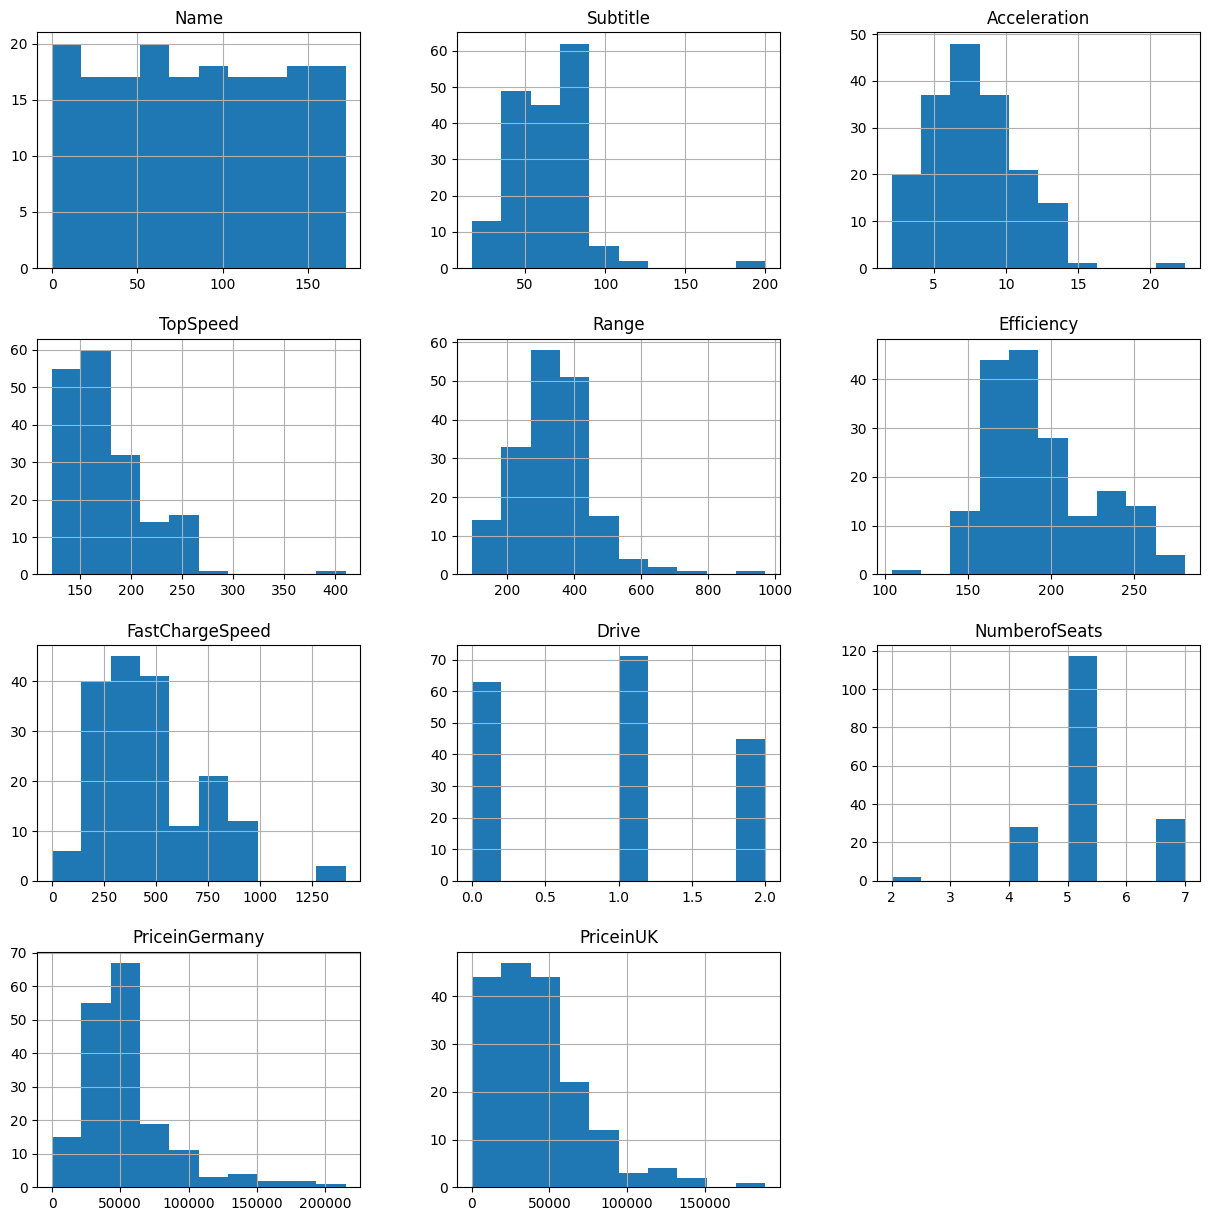

In [37]:
data1.iloc[:,:].hist(figsize=(15,15))
plt.show()

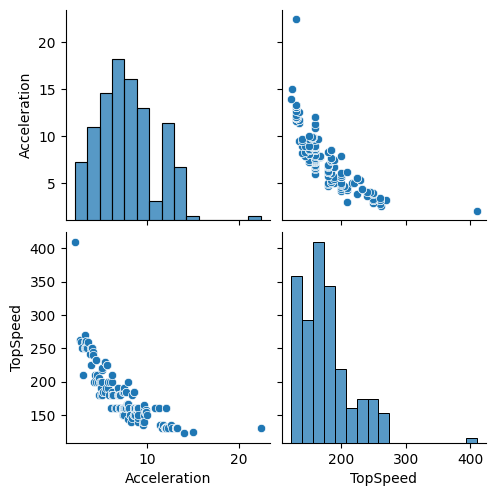

In [38]:
datap=data1[['Acceleration','TopSpeed',]]
sns.pairplot(datap)
plt.show()

In [39]:
data2a=data00[['Name','TopSpeed']]
data2a['TopSpeed(km/h)']=data1['TopSpeed']
data2a=data2a.groupby('Name',as_index=False).max()
data2a=data2a.sort_values('TopSpeed(km/h)',ascending=False)
data2a

<ipython-input-39-db48abe6e3d7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2a['TopSpeed(km/h)']=data1['TopSpeed']


,Name,TopSpeed,TopSpeed(km/h)
156,Tesla Roadster,410 km/h,410
69,Lucid Air Grand Touring,270 km/h,270
153,Tesla Model X Plaid,262 km/h,262
148,Tesla Model 3 Performance,261 km/h,261
59,Kia EV6 GT,260 km/h,260
...,...,...,...
113,Peugeot e-Traveller Standard 75 kWh,130 km/h,130
133,SEAT Mii Electric,130 km/h,130
170,Volkswagen e-Up!,130 km/h,130
37,Dacia Spring Electric,125 km/h,125


In [40]:
fig = px.bar(data2a[0:40], x='Name', y='TopSpeed(km/h)',title="Top Speed Ranknig of Electric Cars")
fig.show()

In [41]:
data2c=data00[['Name','Acceleration']]
data2c['Acceleration(sec)']=data1['Acceleration']
data2c=data2c.groupby('Name',as_index=False).max()
data2c=data2c.sort_values('Acceleration(sec)',ascending=False)
data2c

<ipython-input-41-d4b722fe8686>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Name,Acceleration,Acceleration(sec)
127,Renault Kangoo Maxi ZE 33,22.4 sec,22.4
37,Dacia Spring Electric,15.0 sec,15.0
96,Nissan e-NV200 Evalia,14.0 sec,14.0
103,Opel Zafira-e Life M 75 kWh,13.3 sec,13.3
113,Peugeot e-Traveller Standard 75 kWh,13.3 sec,13.3
...,...,...,...
146,Tesla Cybertruck Tri Motor,3.0 sec,3.0
126,Porsche Taycan Turbo S Cross Turismo,2.9 sec,2.9
125,Porsche Taycan Turbo S,2.8 sec,2.8
153,Tesla Model X Plaid,2.6 sec,2.6


In [42]:
fig = px.bar(data2c[0:40], x='Name', y='Acceleration(sec)',title="Acceleration Ranknig of Electric Cars")
fig.show()

In [43]:
target=['Acceleration']

drop=[]
for i,item in enumerate(data1['Acceleration']):
    if item ==0:
        drop+=[i]
print(drop)
data1=data1.drop(index=data1.index[drop]).reset_index(drop=True)

dataY=data1[target[0]]
dataX=data1.drop(target,axis=1)

[]


In [44]:
print(dataY[0:5].T)
print()
print(dataX[0:5].T)

0    2.1
1    2.6
2    2.8
3    2.9
4    3.0
Name: Acceleration, dtype: float64

                        0         1         2         3        4
Name                156.0     153.0     125.0     126.0    146.0
Subtitle            200.0      90.0      83.7      83.7    200.0
TopSpeed            410.0     262.0     260.0     250.0    210.0
Range               970.0     455.0     390.0     380.0    750.0
Efficiency          206.0     198.0     215.0     220.0    267.0
FastChargeSpeed     920.0     680.0     860.0     790.0    710.0
Drive                 0.0       0.0       0.0       0.0      0.0
NumberofSeats         4.0       7.0       4.0       4.0      7.0
PriceinGermany   215000.0  116990.0  186336.0  187746.0  75000.0
PriceinUK        189000.0  110980.0  138830.0  139910.0  68000.0


In [46]:
import random
n=len(dataX)
print(n)
N=[]
for i in range(n):
    N+=[i]
random.seed(2021)
random.shuffle(N)

179


In [47]:
trainX=dataX.loc[N[0:(n//4)*3]]
trainY=dataY.loc[N[0:(n//4)*3]]
testX=dataX.loc[N[(n//4)*3:]]
testY=dataY.loc[N[(n//4)*3:]]

In [48]:
df_columns = list(dataX.columns)
print(df_columns)

['Name', 'Subtitle', 'TopSpeed', 'Range', 'Efficiency', 'FastChargeSpeed', 'Drive', 'NumberofSeats', 'PriceinGermany', 'PriceinUK']


In [49]:
def create_numeric_feature(input_df):
    use_columns = df_columns 
    return input_df[use_columns].copy()

In [50]:
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [51]:
from tqdm import tqdm

def to_feature(input_df):

    processors = [
        create_numeric_feature,
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [52]:
train_feat_df = to_feature(trainX)
test_feat_df = to_feature(testX)

100%|██████████| 1/1 [00:00<00:00, 144.59it/s]


createcreate_numeric_feature  0.004[s]


100%|██████████| 1/1 [00:00<00:00, 381.51it/s]

createcreate_numeric_feature  0.002[s]


In [53]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, y, cv, 
             params: dict=None, 
             verbose: int=50):

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')
        print()

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [54]:
params = {
    'objective': 'rmse', 
    'learning_rate': .1,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5, 
    'n_estimators': 10000, 
    'colsample_bytree': .5, 
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain', 
    'random_state': 71,
    'num_leaves': 62
}

In [55]:
y = trainY
print(y.shape)
print(type(y))

(132,)
<class 'pandas.core.series.Series'>


In [56]:
ydf=pd.DataFrame(y)
ydf

,Acceleration
24,4.4
115,8.5
108,8.5
94,7.8
176,14.0
...,...
43,5.5
49,5.7
58,6.2
5,3.2


<ipython-input-53-ac7077da9ee2>:12: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argum

fit fold=0  0.060[s]
Fold 0 RMSLE: 1.0161

[500]	valid_0's rmse: 2.25002
fit fold=1  0.167[s]
Fold 1 RMSLE: 2.2401



/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



fit fold=2  0.169[s]
Fold 2 RMSLE: 0.5486

fit fold=3  0.052[s]
Fold 3 RMSLE: 0.9941

fit fold=4  0.046[s]
Fold 4 RMSLE: 0.8551

--------------------------------------------------
FINISHED | Whole RMSLE: 1.2789


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



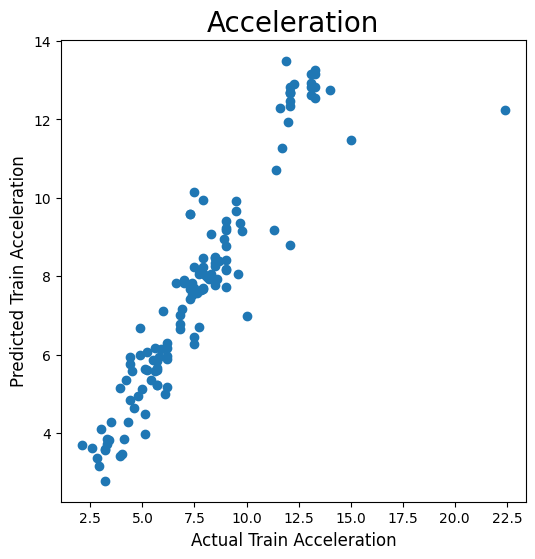

In [57]:
from sklearn.model_selection import KFold

for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    
    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_title(target[i],fontsize=20)
    ax.set_ylabel('Predicted Train '+target[i],fontsize=12)
    ax.set_xlabel('Actual Train '+target[i],fontsize=12)
    ax.scatter(y,oof)

In [58]:
print(target)

['Acceleration']


In [59]:
def visualize_importance(models, feat_train_df):

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    
    ax.tick_params(axis='x', rotation=0)
    #ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig,ax

<ipython-input-53-ac7077da9ee2>:12: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argum

fit fold=0  0.062[s]
Fold 0 RMSLE: 1.0161

[500]	valid_0's rmse: 2.25002
fit fold=1  1.623[s]
Fold 1 RMSLE: 2.2401



/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



fit fold=2  1.414[s]
Fold 2 RMSLE: 0.5486

fit fold=3  0.177[s]
Fold 3 RMSLE: 0.9941

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.





fit fold=4  0.392[s]
Fold 4 RMSLE: 0.8551

--------------------------------------------------
FINISHED | Whole RMSLE: 1.2789


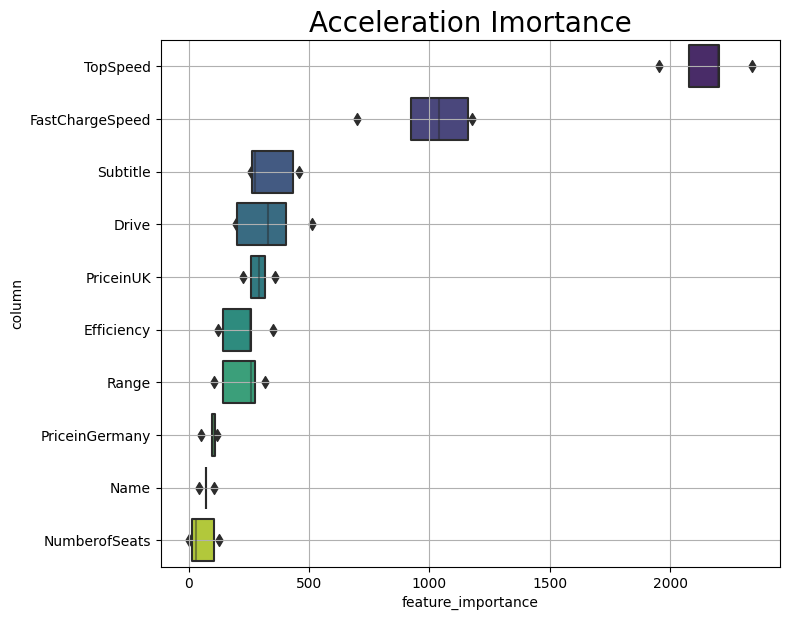

In [60]:
for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    fig, ax = visualize_importance(models, train_feat_df)
    ax.set_title(target[i]+' Imortance',fontsize=20)

In [61]:
pred0 = np.array([model.predict(test_feat_df.values) for model in models])
PRED = pred0[4]
PRED[0:5]

array([12.30713006,  5.15670318,  6.92960139, 11.20615755,  8.9722462 ])

In [62]:
ANS=np.array(testY)
ANS[0:5]

array([11.9,  5.1,  7. , 12.6, 10.9])

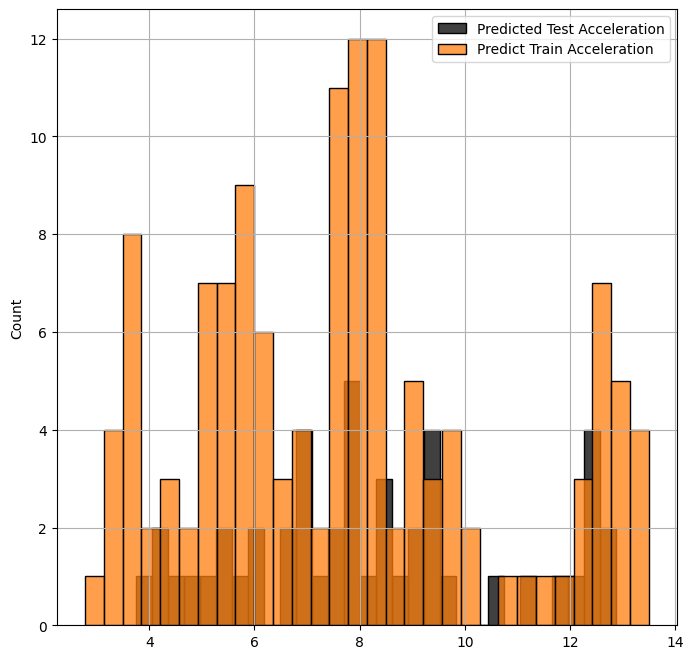

In [63]:
fig, ax = plt.subplots(figsize=(8,8))
sns.histplot(PRED, label='Predicted Test '+target[0], ax=ax, color='black',bins=30)
sns.histplot(oof, label='Predict Train '+target[0], ax=ax, color='C1',bins=30)
ax.legend()
ax.grid()

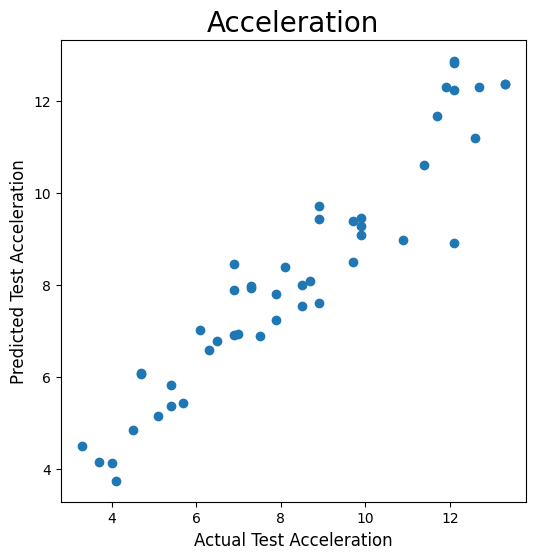

In [64]:
fig,ax = plt.subplots(figsize=(6,6))
ax.set_title(target[0],fontsize=20)
ax.set_xlabel('Actual Test '+target[0],fontsize=12)
ax.set_ylabel('Predicted Test '+target[0],fontsize=12)
ax.scatter(ANS,PRED)

### EV charging station in india

In [67]:
df2 = pd.read_excel('/content/EV_charging_station_dataset.xlsx', sheet_name='Table 2', header=1)
df2.head()

,State,No. of EV chargers sanctioned
0,Maharashtra,317
1,Andhra Pradesh,266
2,Tamil Nadu,281
3,Gujarat,278
4,Uttar Pradesh,207


In [68]:
df3 = pd.read_excel('EV_charging_station_dataset.xlsx', sheet_name='Table 3', header=1)
df3.head()

,National Highway,No. of operational PCS
0,National Highway-10,1
1,National Highway-11,3
2,National Highway-128,1
3,National Highway-13,3
4,National Highway-130,1


In [69]:
df4 = pd.read_excel('EV_charging_station_dataset.xlsx', sheet_name='Table 4', header=1)
df4.head()

,State/UT,EV Charging Facility,Public EV Charging Stations (PCS)
0,1,Andaman & Nicobar,3
1,2,Andhra Pradesh,222
2,3,Arunachal Pradesh,9
3,4,Assam,48
4,5,Bihar,83


In [71]:
print('DF2 Shape: ', df2.shape)
print('DF3 Shape: ', df3.shape)
print('DF4 Shape: ', df4.shape)

DF2 Shape:  (26, 2)
DF3 Shape:  (90, 2)
DF4 Shape:  (34, 3)


In [73]:
print(df2.info())
print(df3.info())
print(df4.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   State                          26 non-null     object
 1   No. of EV chargers sanctioned  26 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 544.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   National Highway        90 non-null     object
 1   No. of operational PCS  90 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Stat

In [74]:
d1 = df2.describe()
d2 = df3.describe()
d3 = df4.describe()

In [75]:
display('DATASET 1 ', d1, 'DATASET 2', d2, 'DATASET 3', d3)

'DATASET 1 '

,No. of EV chargers sanctioned
count,26.000000
mean,221.307692
std,551.474806
min,10.000000
25%,25.000000
50%,71.000000
75%,210.000000
max,2877.000000


'DATASET 2'

,No. of operational PCS
count,90.000000
mean,4.655556
std,6.451480
min,1.000000
25%,2.000000
50%,2.000000
75%,5.000000
max,39.000000


'DATASET 3'

,State/UT,Public EV Charging Stations (PCS)
count,34.000000,34.000000
mean,17.500000,193.705882
std,9.958246,344.290534
min,1.000000,1.000000
25%,9.250000,16.500000
50%,17.500000,54.000000
75%,25.750000,215.250000
max,34.000000,1845.000000


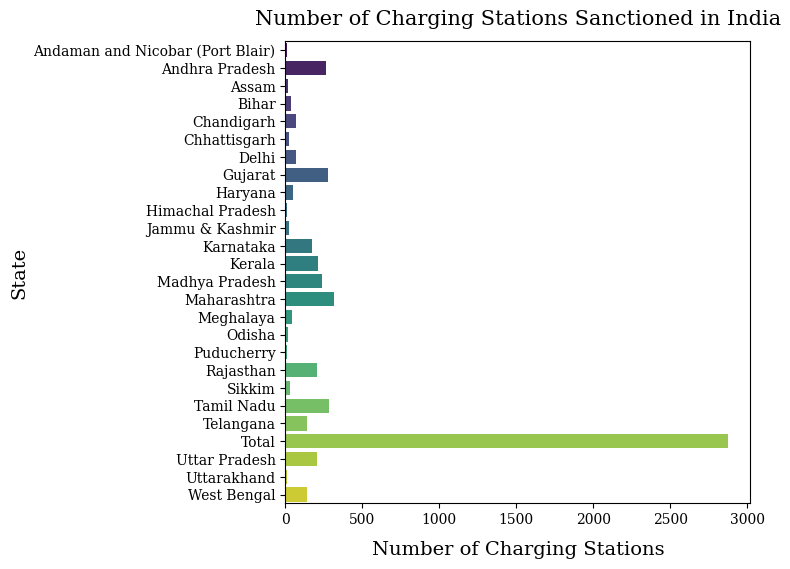

In [76]:
plt.figure(figsize=(6, 6))
sns.barplot(data=df2, y=df2['State'].sort_values(ascending=True), x='No. of EV chargers sanctioned', palette='viridis')
plt.ylabel('State', fontsize=14, family='serif')
plt.xlabel('Number of Charging Stations', family='serif', fontsize=14, labelpad=10)
plt.xticks(family='serif')
plt.yticks(family='serif')
plt.title(label='Number of Charging Stations Sanctioned in India', weight=200, family='serif', size=15, pad=12)
plt.show()

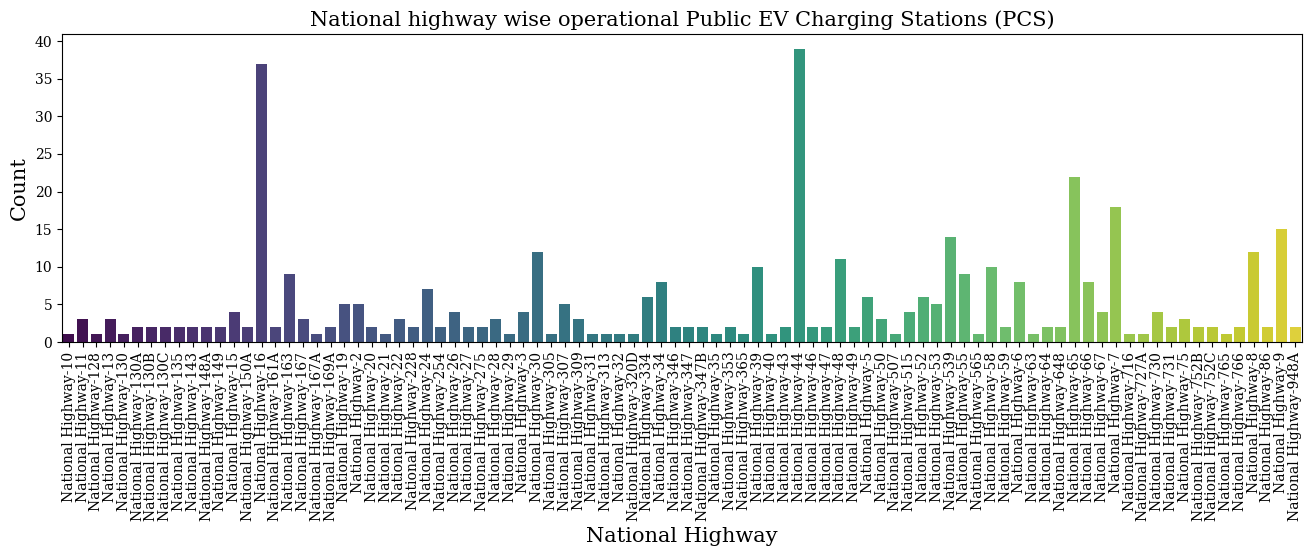

In [77]:
plt.figure(figsize=(16,4))
sns.barplot(data=df3, x='National Highway', y ='No. of operational PCS',palette='viridis')
sns.despine(right=False, top=False)
plt.tick_params(axis='x', rotation=90)
plt.xlabel('National Highway',family='serif', size=15)
plt.ylabel('Count', family='serif', size=15)
plt.xticks(family='serif')
plt.yticks(family='serif')
plt.title('National highway wise operational Public EV Charging Stations (PCS)', family='serif', size=15)
plt.show()